In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import dask
import dask.array as da
import xarray as xr
from netCDF4 import Dataset
import os
from glob import glob
import dask
import dask.array as da

## Load pressure data

In [2]:
# Load data
datadir = '/g/data1/v45/pm2987/Spunup_ocpo/'
ncfiles = sorted(glob(os.path.join(datadir, 'output*/ocpo.nc')))
ncfiles = ncfiles[100:151] #:95] #9:11]
print(ncfiles)

ds = xr.open_mfdataset(ncfiles,data_vars={'p'})
ds

['/g/data1/v45/pm2987/Spunup_ocpo/output125/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output126/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output127/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output128/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output129/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output130/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output131/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output132/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output133/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output134/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output135/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output136/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output137/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output138/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output139/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output140/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output141/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output142/ocpo.nc', '/g/data1/v45/pm2987/Spunup_ocpo/output143/oc

<xarray.Dataset>
Dimensions:  (time: 18615, xp: 961, yp: 961, z: 3, zi: 2)
Coordinates:
  * xp       (xp) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * yp       (yp) float32 0.0 5.0 10.0 15.0 20.0 25.0 30.0 35.0 40.0 45.0 ...
  * z        (z) float32 0.175 0.725 2.55
  * zi       (zi) float32 0.35 1.1
  * time     (time) float64 164.0 164.0 164.0 164.0 164.0 164.0 164.0 164.0 ...
Data variables:
    p        (z, yp, xp, time) float32 dask.array<shape=(3, 961, 961, 18615), chunksize=(3, 961, 961, 365)>
    q        (z, yp, xp, time) float32 dask.array<shape=(3, 961, 961, 18615), chunksize=(3, 961, 961, 365)>
    h        (zi, yp, xp, time) float32 dask.array<shape=(2, 961, 961, 18615), chunksize=(2, 961, 961, 365)>
    taux     (yp, xp, time) float32 dask.array<shape=(961, 961, 18615), chunksize=(961, 961, 365)>
    tauy     (yp, xp, time) float32 dask.array<shape=(961, 961, 18615), chunksize=(961, 961, 365)>
    e        (yp, xp, time) float32 dask.array<shape=(961, 9

## Constants

In [3]:
dx = 5000. # meters
dy = 5000. # meters
dt = 1 # in days
H = [350.0, 750.0, 2900.0]  # meters
Htot = H[0] + H[1] + H[2]
f0 = 9.37456*(10**(-5)) #1/s (Coriolis parameter)
xband_min = 25  # indices
xband_max = 200 # indices
yband_min = 300 # indices
yband_max = 600 # indices
filter_days = 365

## Define u velocity

In [4]:
%%time
u = -(1./(dy*f0)) * np.diff(ds.p.isel(z=0,xp=slice(xband_min,xband_max),yp=slice(yband_min,yband_max)),axis=0) # dimensions are (yp,xp,time)
print(u.shape)

(299, 175, 18615)
CPU times: user 2.46 s, sys: 5.95 s, total: 8.41 s
Wall time: 45.8 s


## Define function to  find maximum of u-velocity

In [5]:
def max_velocity(u):
    nloops = u.shape[2] # number of loops is number of timesteps
    umax = np.zeros(u.shape[2]) # take length of time axis
    umax_magn = np.zeros(u.shape[2])
    for i in np.arange(nloops):
        u_loop = u[:,:,i]
        u_loop = np.mean(u_loop,axis=1)
        umax[i] = np.argmax(u_loop)
        umax_magn[i] = np.max(u_loop)
    return umax,umax_magn

## Define Fourier filter function

In [6]:
def Fourier_filter(u):
    W = np.fft.rfftfreq(u.shape[2],d=1)
    u_filter = np.fft.rfft(u,axis=2)
    cut_u_filter = u_filter.copy()
    cut_u_filter[:,:,W>(1/filter_days)] = 0
    cut_u_filter[:,:,W<(-1/filter_days)] = 0
    cut_u = np.fft.irfft(cut_u_filter,axis=2)
    return cut_u

## Call the above functions

In [7]:
%%time
filtered_u = Fourier_filter(u)
umax_filtered,umax_magn_filtered = max_velocity(filtered_u)

MemoryError: 

## Plot max velocity amplitude over time

(2190,)


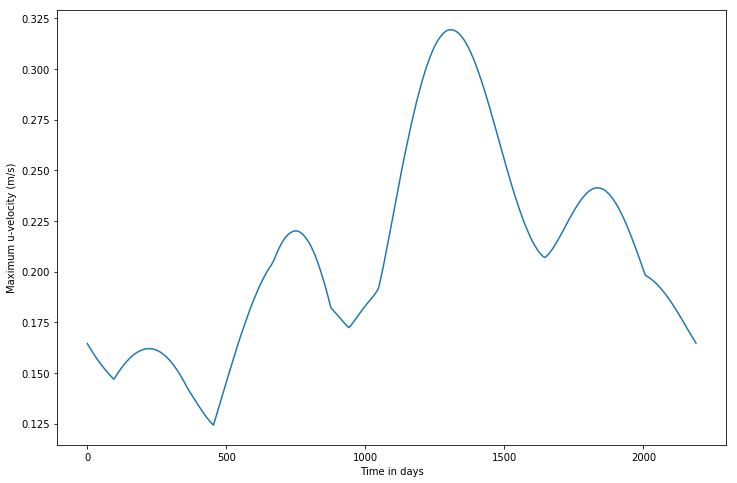

In [9]:
# For 2-year filter on 5 years

plt.figure(figsize=(12,8))
plt.plot(umax_magn_filtered)
plt.xlabel('Time in days')
plt.ylabel('Maximum u-velocity (m/s)')
print(umax_magn_filtered.shape)

(7664,)


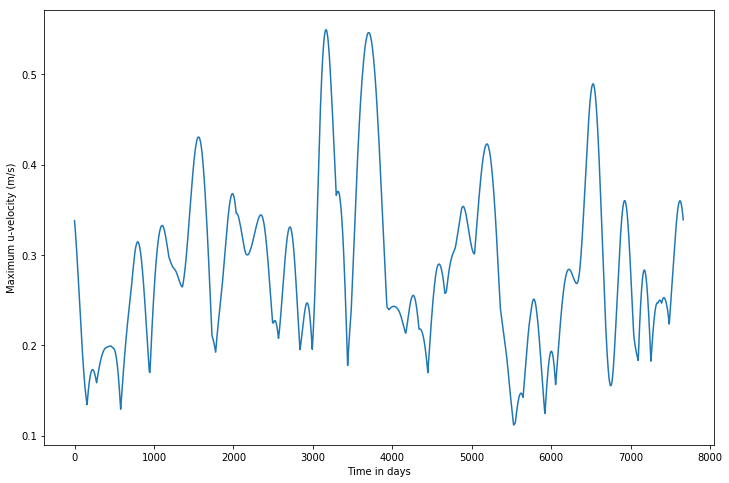

In [13]:
# For 1-year filter on 20 years

plt.figure(figsize=(12,8))
plt.plot(umax_magn_filtered)
plt.xlabel('Time in days')
plt.ylabel('Maximum u-velocity (m/s)')
print(umax_magn_filtered.shape)

## Plot location of maximum velocity over time

(7664,)


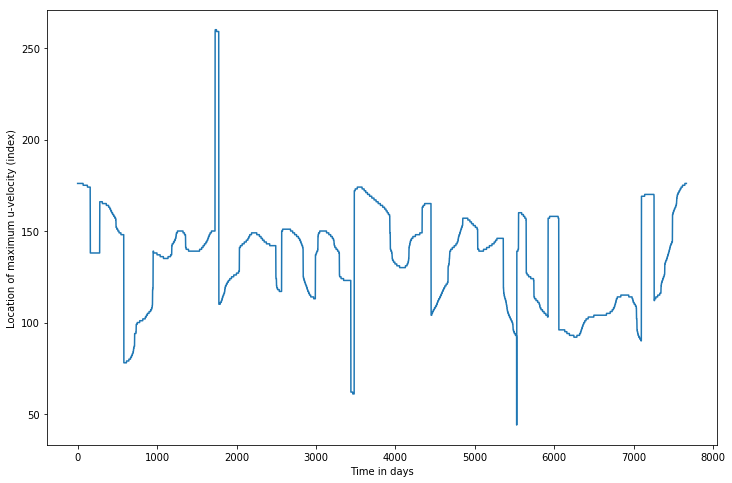

In [14]:
# For 1-year filter on 20 years

plt.figure(figsize=(12,8))
plt.plot(umax_filtered)
plt.xlabel('Time in days')
plt.ylabel('Location of maximum u-velocity (index)')
print(umax_magn_filtered.shape)